# Py-ART Animation
### Choosing the radar volume from a Australian radar site over a time span. 

### Original notebook by Zach Sherman:
https://github.com/uq-crg/pyart_animation

### Based on code by Scott Collis:
https://github.com/scollis/radar_in_the_cloud/blob/master/notebooks/Matthew.ipynb 

### Jonathan Helmus:
https://anaconda.org/jjhelmus/scipy2015_openaccessradar_jjh/notebook

### and memory fixes by Robert Jackson:
https://github.com/rcjackson/pyart_practice/blob/master/nexrad_animatedgif.py

Note: AUS radar s3 files are set in UTC. 

In [8]:
from boto.s3.connection import S3Connection
import pyart
import gzip
from matplotlib import pyplot as plt
from datetime import date, datetime, timedelta
from matplotlib import animation
from mpl_toolkits.basemap import Basemap
from owslib.wms import WebMapService
import tempfile
import numpy as np
import pandas as pd
from IPython.display import Image, display
%matplotlib inline
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

Installed autotime.py. To use it, type:
  %load_ext autotime
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.09 s


In [9]:
# Function for pulling all keys between two dates at a chosen nexrad site.

def ausrad_site_datespan(start_date=None, start_time=None, 
                         end_date=None, end_time=None, site=None):
    
    """
    Get all volumes of NEXRAD data between two particular datetimes.
    Parameters
    ----------
    start_date : string
        eight number date, for example '20150623'
    start_date_time : string
        six number time, for example '145501'
    end_date : string
        eight number date or 'Now' to retrieve current UTC
    end_date_time : string, optional if end_date = 'Now'
        six number time
    site : string
        two digit radar designation number, for example '02' 
        
    """
    
    def datespan(startDate, endDate, delta=timedelta(days=1)):
        currentDate = startDate
        while currentDate < endDate:
            yield currentDate
            currentDate += delta

    fmt = '%Y/%m/%d_%H:%M:%S' 
    
    # Allows for the choice of now for the end date so current UTC is pulled.
    
    if end_date.upper() == 'NOW':
        e_d_selected = datetime.utcnow()
    else:
        e_d_selected = datetime.strptime(end_date + '_' + end_time, fmt)

    s_d = datetime.strptime(start_date + '_' + start_time, fmt)
    e_d = e_d_selected 

    if s_d > e_d_selected:
            raise ValueError('You provided a start date that comes after the end date.')

    times = []
    for timestamp in datespan((s_d), (e_d), delta=timedelta(days=1)):
        time = timestamp
        times += ["odimh5_archive/" + site + '/' + datetime.strftime(time, '%Y/%m/%d/')]

    print times
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('roames-wxradar-archive')
    
    #Get a list of files 
    
    keys = []
    datetimes = []
    for time in times:
        bucket_list = list(bucket.list(time))   
        for i in range(len(bucket_list)):
            this_str = str(bucket_list[i].key)
            if 'h5' in this_str:
                endme = this_str[-18:-3]
                fmt = '%Y%m%d_%H%M%S' 
                dt = datetime.strptime(endme, fmt)
                datetimes.append(dt)
                keys.append(bucket_list[i])

    # Code belows chooses all keys between the user's dates.
    
    d = {'keys': keys}
    key_object = pd.DataFrame(data=d, index=pd.to_datetime(datetimes))

    selected_keys = key_object.loc[s_d : e_d, :]
    #radar_datetimes = selected_keys.index.tolist()
    data_keys = selected_keys['keys'].tolist()
    return data_keys

time: 56.4 ms


In [10]:
# Conversion of keys to pyart radar objects.

def radar_keys_to_data(keys):
    localfile = tempfile.NamedTemporaryFile()
    keys.get_contents_to_filename(localfile.name)
    # Only pulling two scans for the sake of time.
    radar = pyart.aux_io.read_odim_h5(localfile.name, file_field_names=True)
    radar.fields['DBZH']['standard_name'] = 'Reflectivity'
    radar.fields['DBZH']['units'] = 'dBZ'
    radar.fields['DBZH']['long_name'] = 'Radar Reflectivity Factor'
    return radar

time: 3.74 ms


In [11]:
def generate_layers(max_lat,min_lat,max_lon,min_lon):
    
    #generate map bounds
    lat_dif   = max_lat-min_lat
    lon_dif   = max_lon-min_lon
    map_x_sz  = int(500*lon_dif)
    map_y_sz  = int(500*lat_dif)

    #create overly map
    wms = WebMapService('http://services.ga.gov.au/site_7/services/Topographic_Base_Map_WM/MapServer/WMSServer?', version='1.1.1')
    img = wms.getmap(layers=['Roads_4','Populated_Places_6'],srs='EPSG:4326',bbox=(min_lon, min_lat, max_lon, max_lat),size=(map_x_sz, map_y_sz),format='image/png',transparent=True)
    out = open('overlay.png', 'wb')
    out.write(img.read())
    out.close()  

    #create background map
    wms = WebMapService('http://ows.terrestris.de/osm-gray/service?', version='1.1.1')
    img = wms.getmap(layers=['TOPO-WMS'],srs='EPSG:4326',bbox=(min_lon, min_lat, max_lon, max_lat),size=(map_x_sz, map_y_sz),format='image/png',transparent=True)
    out = open('background.png', 'wb')
    out.write(img.read())
    out.close() 

time: 13.8 ms


In [12]:
# Creating a gif of all volumes between both dates.
def animate(nframe):
    
    #create basemap
    plt.clf()
    ref_m = Basemap(llcrnrlon=min_lon,
            llcrnrlat=min_lat,
            urcrnrlon=max_lon,
            urcrnrlat=max_lat, 
            projection='tmerc', 
            resolution = 'f',
            epsg = 3857)
    #load background image
    im = plt.imread('background.png')
    ref_m.imshow(im,zorder = 0,origin='upper')
    #plot radar data
    radar = radar_keys_to_data(my_data_keys[nframe])
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map(field, sweep=sweep, resolution=bm_res,
                         vmin=vmin, vmax=vmax, mask_outside=False,
                         cmap=cmap,lat_lines=lal, lon_lines=lol,
                         basemap = ref_m, zorder = 1)
    #overlay mapping data
    im = plt.imread('overlay.png')
    ref_m.imshow(im,zorder = 2,origin='upper')
    #overlay countries
    display.basemap.drawcounties()

time: 16.1 ms


In [14]:
# Plotting and creating an animation using the radar datas.
# Something close to home.
# Use the option of saying 'now' to retrieve current UTC.

#config vars
radar_id     = '66'
field        = 'DBZH'
sweep        = 1
vmin         = 0
vmax         = 65
start_date   = '2008/11/16'
start_time   = '05:00:00'
end_date     = '2008/11/16'
end_time     = '07:00:00'
max_lat      = -27
min_lat      = -28.16
min_lon      = 152.2
max_lon      = 153.5
lat_grid     = 0.2
lon_grid     = 0.2
bm_res       = 'h' #l (low), i (intermediate), h (high), f (full)
cmap         = pyart.graph.cm.NWSRef


lal = np.arange(min_lat, max_lat, lat_grid)
lol = np.arange(min_lon, max_lon, lon_grid)

# build keys
my_data_keys = ausrad_site_datespan(start_date=start_date,start_time=start_time,
                                         end_date=end_date,end_time=end_time,
                                         site=radar_id)
#confirm keys
print(my_data_keys)

generate_layers(min_lat = min_lat,max_lat = max_lat,
                min_lon = min_lon, max_lon = max_lon)

fig = plt.figure(figsize=(10, 8))
anim_66 = animation.FuncAnimation(fig, animate, frames=len(my_data_keys))
anim_66.save('/home/meso/test.gif', writer='ImageMagick', fps=5)
plt.close()

['odimh5_archive/66/2008/11/16/']
[<Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_050034.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_050633.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_051233.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_051833.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_052433.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_053033.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_053633.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_054234.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_054833.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_055434.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_060035.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20

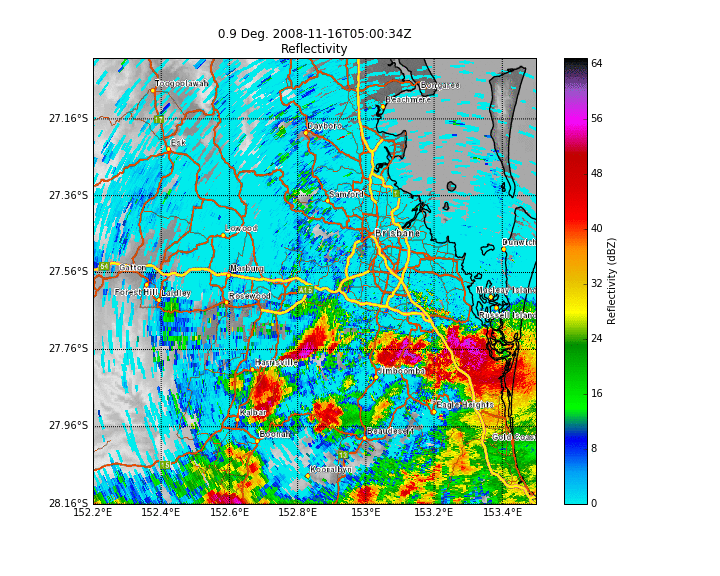

time: 160 ms


In [15]:
# The gifs created will not run inline in Jupyter Notebook unless the gif files are opened.

with open('/home/meso/test.gif','rb') as f:
    display(Image(f.read()), format='png')